<a href="https://colab.research.google.com/github/praykar/codesimple/blob/main/drivers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver Churn
Recruiting and retaining drivers is seen by industry watchers as a tough battle for Company A. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to other Company B depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, A is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

Data contains monthly information for a segment of drivers for 2019 and 2020 and task is to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)


# EDA

In [105]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb

In [106]:
!gdown 1rhFCuPRYczDPdDtJXymIIqsih6pqw-rk

Downloading...
From: https://drive.google.com/uc?id=1rhFCuPRYczDPdDtJXymIIqsih6pqw-rk
To: /content/driver_data.csv
100% 1.13M/1.13M [00:00<00:00, 109MB/s]


In [107]:
df = pd.read_csv('driver_data.csv')

In [108]:
df.head(10)

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
5,5,12/01/19,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
6,6,01/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
7,7,02/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
8,8,03/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,350000,1
9,9,04/01/20,4,43.0,0.0,C13,2,65603,12/07/19,27/04/20,2,2,0,1


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


Column Profiling:
- **Dropping Unnamed columns as it is serial number**
- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)


In [110]:
df['Reporting_date']= pd.to_datetime(df['MMM-YY'])
df['Date_of_joining']= pd.to_datetime(df['Dateofjoining'])
df['Last_working_date']= pd.to_datetime(df['LastWorkingDate'])
df.drop(['MMM-YY','Dateofjoining','LastWorkingDate'], inplace= True, axis =1)

- Converting to datetime format
- Dropping Unnamed column having serial numbers

In [111]:
df.drop(['Unnamed: 0'], inplace= True, axis =1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             19104 non-null  int64         
 1   Age                   19043 non-null  float64       
 2   Gender                19052 non-null  float64       
 3   City                  19104 non-null  object        
 4   Education_Level       19104 non-null  int64         
 5   Income                19104 non-null  int64         
 6   Joining Designation   19104 non-null  int64         
 7   Grade                 19104 non-null  int64         
 8   Total Business Value  19104 non-null  int64         
 9   Quarterly Rating      19104 non-null  int64         
 10  Reporting_date        19104 non-null  datetime64[ns]
 11  Date_of_joining       19104 non-null  datetime64[ns]
 12  Last_working_date     1616 non-null   datetime64[ns]
dtypes: datetime64[ns

In [112]:
grp = df.groupby('Driver_ID')
drivers = grp.agg({'Age':'last','Gender':'last','City':'last','Education_Level':'last','Income':'last','Joining Designation':'first','Grade':'last',
         'Total Business Value':'sum','Quarterly Rating':'mean','Reporting_date':'last','Date_of_joining':'min','Last_working_date':'last'})
drivers

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Reporting_date,Date_of_joining,Last_working_date
Driver_ID,,,,,,,,,,,,
1,28.0,0.0,C23,2,57387,1,1,1715580,2.000000,2019-03-01,2018-12-24,2019-03-11
2,31.0,0.0,C7,2,67016,2,2,0,1.000000,2020-12-01,2020-11-06,NaT
4,43.0,0.0,C13,2,65603,2,2,350000,1.000000,2020-04-01,2019-12-07,2020-04-27
5,29.0,0.0,C9,0,46368,1,1,120360,1.000000,2019-03-01,2019-01-09,2019-03-07
6,31.0,1.0,C11,1,78728,3,3,1265000,1.600000,2020-12-01,2020-07-31,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
2784,34.0,0.0,C24,0,82815,2,3,21748820,2.625000,2020-12-01,2015-10-15,NaT
2785,34.0,1.0,C9,0,12105,1,1,0,1.000000,2020-10-01,2020-08-28,2020-10-28
2786,45.0,0.0,C19,0,35370,2,2,2815090,1.666667,2019-09-01,2018-07-31,2019-09-22


Target Variable Encoding: Last_working_date
- 0 : Driver currently working
- 1 : Driver left (churn)

In [113]:
drivers['Last_working_date']= np.where(drivers['Last_working_date'].isnull(),0,1)

In [114]:
print('Driver Churn Percentage %\n',round(drivers['Last_working_date'].value_counts(normalize = True) * 100,2))

Driver Churn Percentage %
 1    67.87
0    32.13
Name: Last_working_date, dtype: float64


**Missing value**

In [115]:
miss_values = round(((drivers.isnull().sum()/len(drivers)) * 100),2)
miss_values

Age                     0.0
Gender                  0.0
City                    0.0
Education_Level         0.0
Income                  0.0
Joining Designation     0.0
Grade                   0.0
Total Business Value    0.0
Quarterly Rating        0.0
Reporting_date          0.0
Date_of_joining         0.0
Last_working_date       0.0
dtype: float64

No missing values after aggregation

**Feature Engineering**

- Improved_Rating : Drivers for those whose quarterly rating has increased we assign the value 1

In [116]:
x = df.groupby('Driver_ID')['Quarterly Rating'].agg(['first','last'])
drivers['Improved_Rating'] = np.where((x['last']- x['first']) > 0 , 1, 0)
drivers.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Reporting_date,Date_of_joining,Last_working_date,Improved_Rating
Driver_ID,,,,,,,,,,,,,
1,28.0,0.0,C23,2,57387,1,1,1715580,2.0,2019-03-01,2018-12-24,1,0
2,31.0,0.0,C7,2,67016,2,2,0,1.0,2020-12-01,2020-11-06,0,0
4,43.0,0.0,C13,2,65603,2,2,350000,1.0,2020-04-01,2019-12-07,1,0
5,29.0,0.0,C9,0,46368,1,1,120360,1.0,2019-03-01,2019-01-09,1,0
6,31.0,1.0,C11,1,78728,3,3,1265000,1.6,2020-12-01,2020-07-31,0,1


- Monthly income for those driver whose monthly income has increased we assign the value 1

In [117]:
y = df.groupby('Driver_ID')['Income'].agg(['first','last'])
drivers['Increased_income'] = np.where((y['last']- y['first']) > 0 , 1, 0)
drivers.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Reporting_date,Date_of_joining,Last_working_date,Improved_Rating,Increased_income
Driver_ID,,,,,,,,,,,,,,
1,28.0,0.0,C23,2,57387,1,1,1715580,2.0,2019-03-01,2018-12-24,1,0,0
2,31.0,0.0,C7,2,67016,2,2,0,1.0,2020-12-01,2020-11-06,0,0,0
4,43.0,0.0,C13,2,65603,2,2,350000,1.0,2020-04-01,2019-12-07,1,0,0
5,29.0,0.0,C9,0,46368,1,1,120360,1.0,2019-03-01,2019-01-09,1,0,0
6,31.0,1.0,C11,1,78728,3,3,1265000,1.6,2020-12-01,2020-07-31,0,1,0


- Univariate Analysis

In [118]:
continuos = ['Age','Income','Total Business Value','Quarterly Rating','Reporting_date','Date_of_joining']
category = ['Gender','Education_Level','Joining Designation','Grade','Improved_Rating','Increased_income','City']

In [119]:
for i in category:
  print(i)
  print(drivers[i].value_counts())

Gender
0.0    1404
1.0     977
Name: Gender, dtype: int64
Education_Level
2    802
1    795
0    784
Name: Education_Level, dtype: int64
Joining Designation
1    1026
2     815
3     493
4      36
5      11
Name: Joining Designation, dtype: int64
Grade
2    855
1    741
3    623
4    138
5     24
Name: Grade, dtype: int64
Improved_Rating
0    2023
1     358
Name: Improved_Rating, dtype: int64
Increased_income
0    2338
1      43
Name: Increased_income, dtype: int64
City
C20    152
C15    101
C29     96
C26     93
C8      89
C27     89
C10     86
C16     84
C22     82
C3      82
C28     82
C12     81
C5      80
C1      80
C21     79
C14     79
C6      78
C4      77
C7      76
C9      75
C25     74
C23     74
C24     73
C19     72
C2      72
C17     71
C13     71
C18     69
C11     64
Name: City, dtype: int64


Count of  Gender


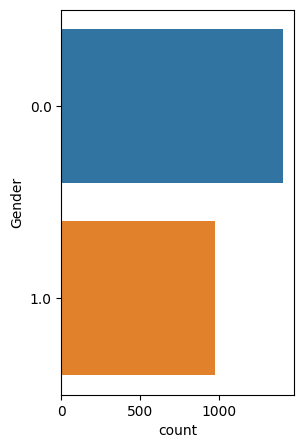

Count of  Education_Level


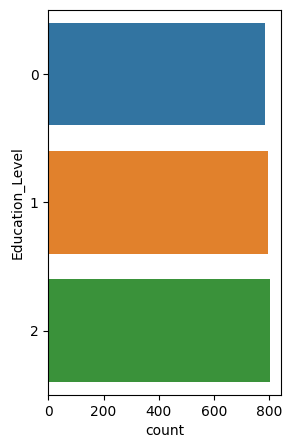

Count of  Joining Designation


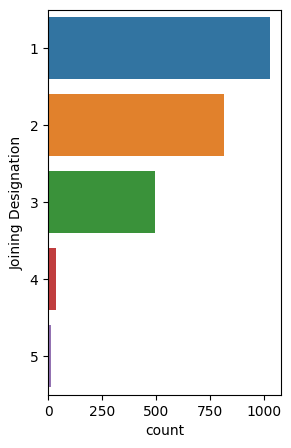

Count of  Grade


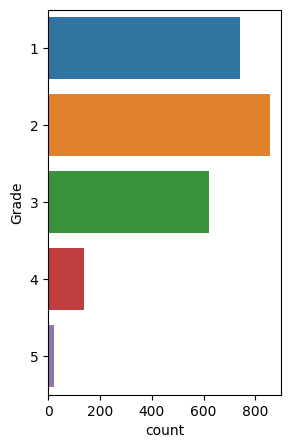

Count of  Improved_Rating


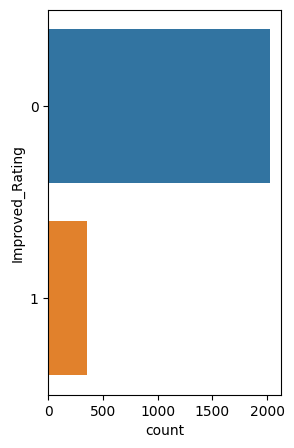

Count of  Increased_income


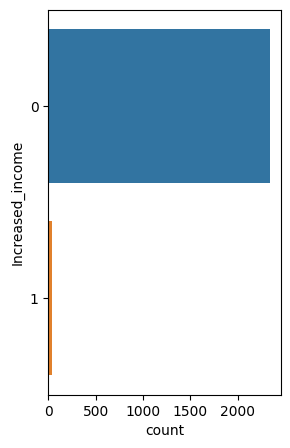

Count of  City


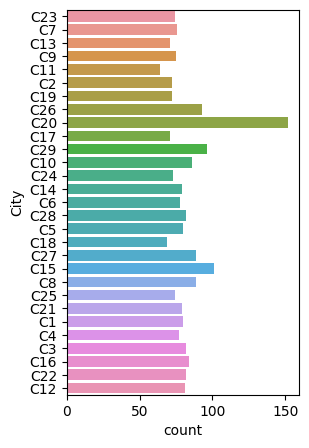

In [120]:
for i in category:
  plt.figure(figsize=(3,5))
  print('Count of ',i)
  sns.countplot(y=drivers[i])
  plt.show()

Distribution of Age across dataset


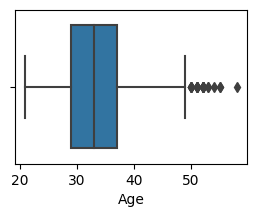

Distribution of Income across dataset


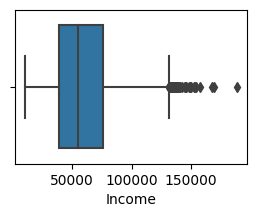

Distribution of Total Business Value across dataset


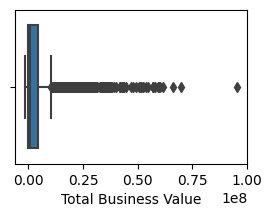

Distribution of Quarterly Rating across dataset


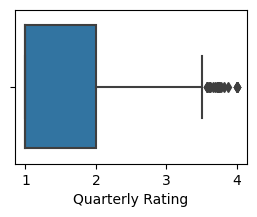

In [121]:
for i in continuos[:-2]:
  plt.figure(figsize=(3,2))
  print(f'Distribution of {i} across dataset')
  sns.boxplot(data = drivers , x=i)
  plt.show()

- Missing values and Outlier detection

In [122]:
print('Data points before outlier removal',drivers.shape[0])
for col in continuos[:-2]:
    mean = drivers[col].mean()
    std = drivers[col].std()

    upper_limit = mean+3*std
    lower_limit = mean-3*std

    drivers = drivers[(drivers[col]<upper_limit) & (drivers[col]>lower_limit)]
print('Data points after outlier removal',drivers.shape[0])

Data points before outlier removal 2381
Data points after outlier removal 2274


- Bivariate Analysis

<Axes: xlabel='Grade', ylabel='count'>

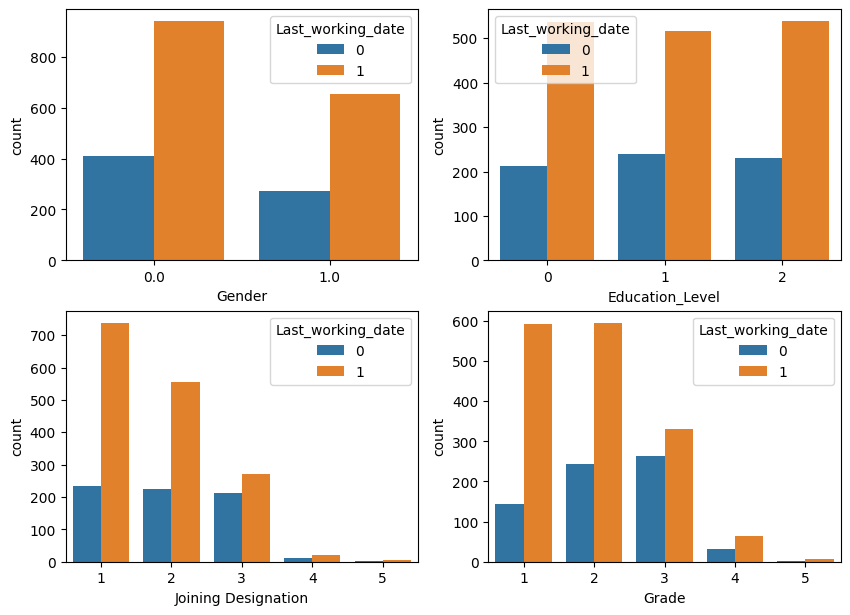

In [123]:
plt.figure(figsize=(10, 15))

plt.subplot(4, 2, 1)
sns.countplot(x='Gender', data=drivers, hue='Last_working_date')

plt.subplot(4, 2, 2)
sns.countplot(x='Education_Level', data=drivers, hue='Last_working_date')

plt.subplot(4, 2, 3)
sns.countplot(x='Joining Designation', data=drivers, hue='Last_working_date')

plt.subplot(4, 2, 4)
sns.countplot(x='Grade', data=drivers, hue='Last_working_date')

- Higher Driver Churn observed in low average grade and low joining designation.  

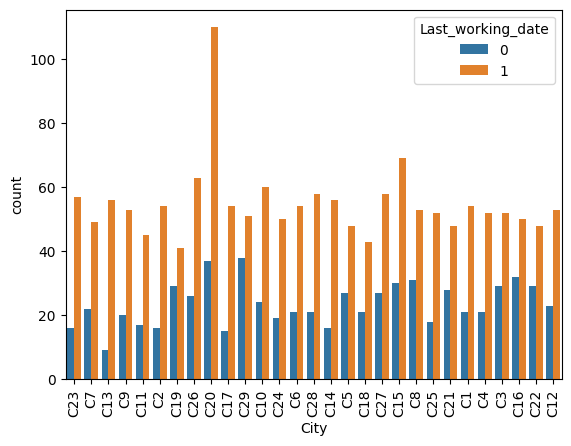

In [124]:
g = sns.countplot(x='City', data=drivers, hue='Last_working_date')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

- Highest number of drivers left in City **C20**.
- Ratio of drivers left is HIGH in following Cities:
  - C2
  - C13
  - C17
  - C14
  - C20
  - C25

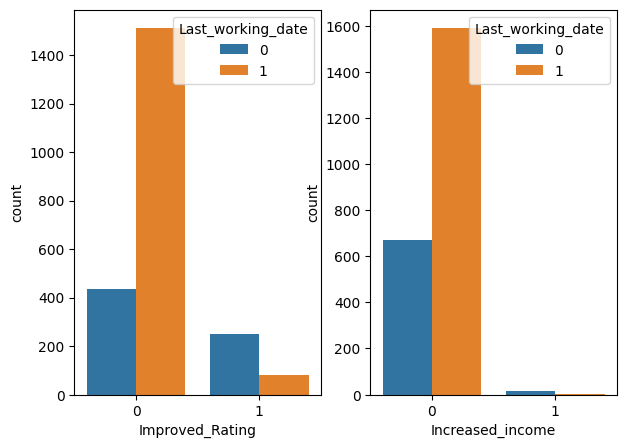

In [125]:
plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Improved_Rating', data=drivers, hue='Last_working_date')

plt.subplot(1, 2, 2)
sns.countplot(x='Increased_income', data=drivers, hue='Last_working_date')
plt.show()

- Churn is comparatively lesser for drivers where income and rating is improved

<ipython-input-126-816907148d03>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(drivers.corr(method='spearman'), annot=True, cmap='viridis')


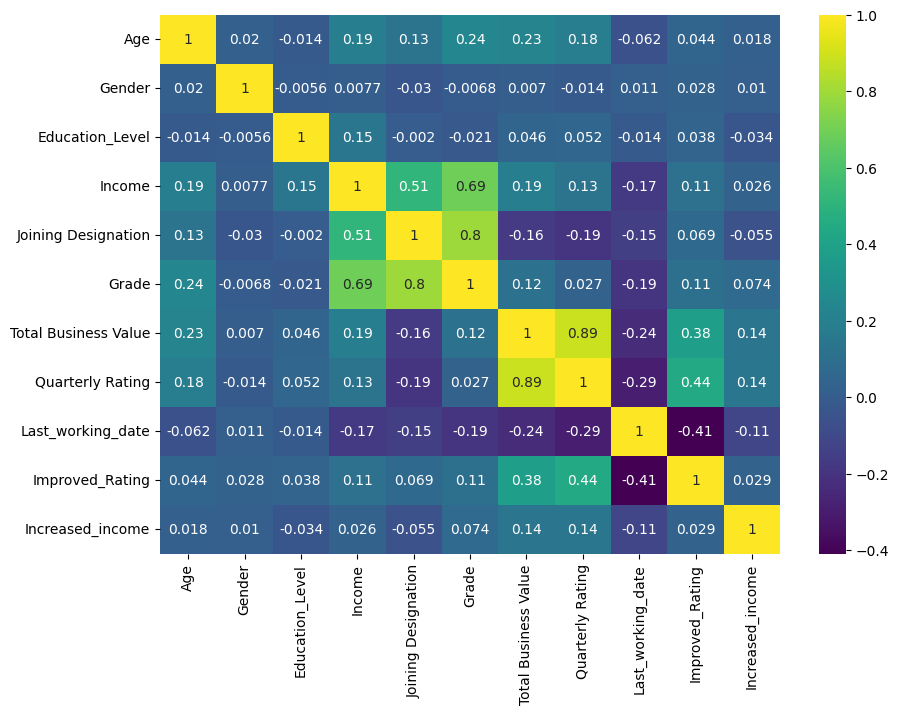

In [126]:
plt.figure(figsize=(10, 7))
sns.heatmap(drivers.corr(method='spearman'), annot=True, cmap='viridis')
plt.show()

Features positively correlated:
- Income with **Grade** & **Joining Designation**.
- Total Business Value with **Average Quaterly Rating**

- Statistical summary of the derived dataset

In [127]:
drivers.describe()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Last_working_date,Improved_Rating,Increased_income
count,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2.274000e+03,2274.000000,2274.000000,2274.000000,2274.000000
mean,33.403254,0.406332,1.008795,57420.381706,1.821900,2.034301,3.270880e+06,1.504097,0.699648,0.143799,0.006596
std,5.760860,0.491256,0.817167,26528.905621,0.831324,0.889229,5.803025e+06,0.655109,0.458512,0.350963,0.080967
min,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-1.385530e+06,1.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.000000,38410.750000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,1.000000,54114.500000,2.000000,2.000000,6.563350e+05,1.000000,1.000000,0.000000,0.000000
75%,37.000000,1.000000,2.000000,73082.750000,2.000000,3.000000,3.313180e+06,2.000000,1.000000,0.000000,0.000000
max,51.000000,1.000000,2.000000,140833.000000,5.000000,5.000000,3.031878e+07,3.500000,1.000000,1.000000,1.000000


# Model Building
- One hot encoding

In [128]:
drivers = pd.get_dummies(drivers, columns=category, drop_first=True)
drivers.shape

(2274, 48)

- Data Preparation for Modeling

In [129]:
X = drivers.drop(['Last_working_date','Reporting_date','Date_of_joining'], axis=1)
y = drivers['Last_working_date']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1591, 45)
(683, 45)


#### MinMaxScaler -

For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

In [131]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

- Class Imbalance Treatment

<Axes: xlabel='Driver_ID', ylabel='Income'>

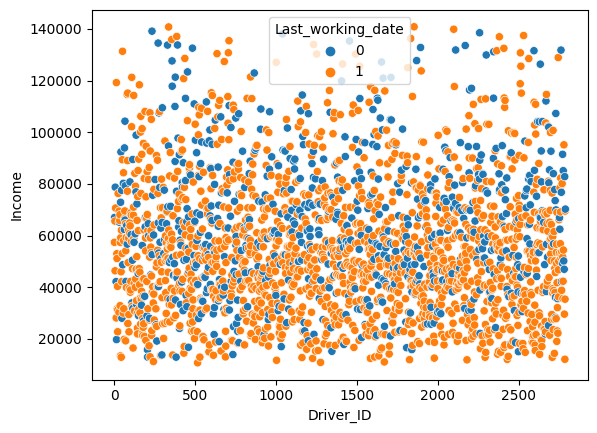

In [132]:
sns.scatterplot(data = drivers,x = 'Driver_ID', y = 'Income', hue = 'Last_working_date')

In [133]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (2226, 45)
After OverSampling, the shape of train_y: (2226,) 

After OverSampling, counts of label '1': 1113
After OverSampling, counts of label '0': 1113


#### Model : Ensemble: RFC

In [134]:
rfc = RandomForestClassifier(n_jobs=-1)
params = {
    'n_estimators' : [200, 300, 400],
    'max_depth' : [5, 7],
    'criterion' : ['gini', 'entropy'],
    'max_features' : [9, 10]
}
model = RandomizedSearchCV(rfc, params, scoring = "accuracy", cv=3, n_jobs = -1)

In [135]:
model.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 7],
                                        'max_features': [9, 10],
                                        'n_estimators': [200, 300, 400]},
                   scoring='accuracy')

In [136]:
clf = RandomForestClassifier(**model.best_params_)
clf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=7, max_features=9, n_estimators=400)

In [137]:
clf.score(X_test, y_test)

0.7540263543191801

In [138]:
clf.score(X_train_res, y_train_res)

0.8041329739442947

#Model: Ensemble: GBC

In [139]:
gridParams = {
    "n_estimators": [50,100,150,200],
    "max_depth" : [3, 4, 5, 7],
    "max_leaf_nodes" : [20, 40, 80],
    "learning_rate": [0.1, 0.2, 0.3]
    }
boostclf = GradientBoostingClassifier()
model1 = RandomizedSearchCV(boostclf,gridParams,verbose=3,cv=3,n_jobs = -1,n_iter=10)

In [140]:
model1.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 7],
                                        'max_leaf_nodes': [20, 40, 80],
                                        'n_estimators': [50, 100, 150, 200]},
                   verbose=3)

In [141]:
clf1 = GradientBoostingClassifier(**model1.best_params_)
clf1.fit(X_train_res, y_train_res)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_leaf_nodes=20,
                           n_estimators=150)

In [142]:
clf1.score(X_test, y_test)

0.7525622254758418

In [143]:
clf1.score(X_train_res, y_train_res)

0.9932614555256065

####Confusion Matrix

1. Random Forest Classifier

In [144]:
y_pred_1 = clf.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred_1)
print(confusion_matrix)

[[131  74]
 [ 94 384]]


2. Gradient Boosting Classifier

In [145]:
from sklearn.metrics import confusion_matrix
y_pred_2 = clf1.predict(X_test)
confusion_matrix1 = confusion_matrix(y_test, y_pred_2)
print(confusion_matrix1)

[[115  90]
 [ 79 399]]


#### Classification Report -

In [146]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       205
           1       0.84      0.80      0.82       478

    accuracy                           0.75       683
   macro avg       0.71      0.72      0.71       683
weighted avg       0.76      0.75      0.76       683



In [147]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.59      0.56      0.58       205
           1       0.82      0.83      0.83       478

    accuracy                           0.75       683
   macro avg       0.70      0.70      0.70       683
weighted avg       0.75      0.75      0.75       683



#### ROC Curve -

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

- TPR=(TP)/(TP+FN)

False Positive Rate (FPR) is defined as follows:

- FPR=(FP)/(FP+TN)

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.
#### AUC (Area under the ROC Curve) -

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).
e.g.
When AUC is 0.7, it means there is a 70% chance that the model will be able to distinguish between positive class and negative class.
AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of predictions:

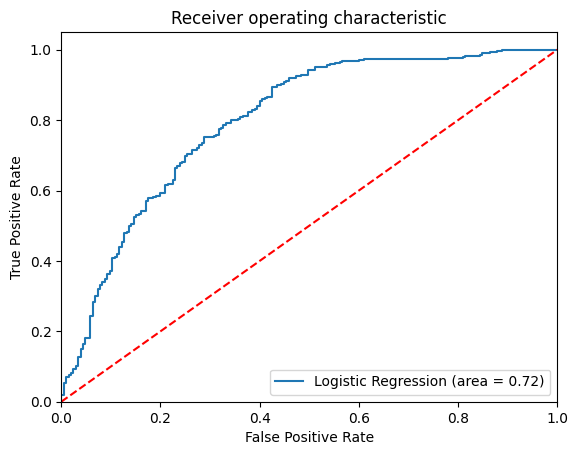

In [148]:
logit_roc_auc = roc_auc_score(y_test, y_pred_1)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

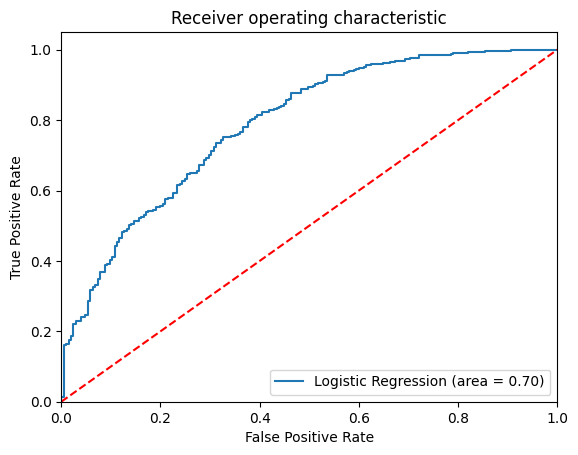

In [149]:
logit_roc_auc = roc_auc_score(y_test, y_pred_2)
fpr, tpr, thresholds = roc_curve(y_test, clf1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

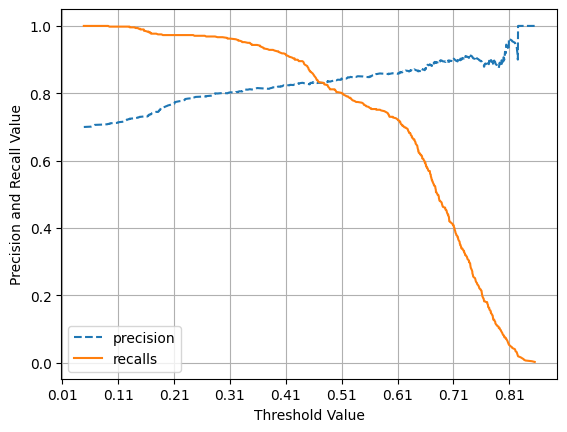

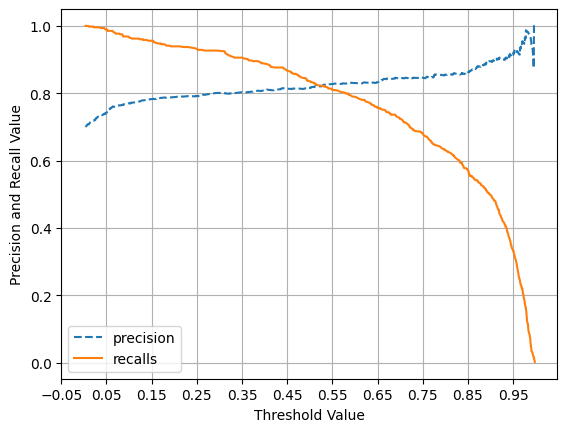

In [150]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, clf.predict_proba(X_test)[:,1])
precision_recall_curve_plot(y_test, clf1.predict_proba(X_test)[:,1])

#Insights & Recommendations

